# Algo Trading News or Noise

## Imports
---

In [662]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from dotenv import load_dotenv
import panel as pn
from panel.interact import interact
from panel import widgets
import alpaca_trade_api as tradeapi
import quandl
import os
import requests
import ccxt
import time
import tensorflow

## Read in data
---

In [663]:
ETF_csv = Path("Resources/ETFs0.csv")
ETF_df = pd.read_csv(ETF_csv, index_col='Unnamed: 0', infer_datetime_format=True, parse_dates=True)
ETF_df = ETF_df.drop(ETF_df.index[0])
ETF_df.index = pd.to_datetime(ETF_df.index, utc=True).date
ETF_df.sort_index(inplace=True)
ETF_df.tail()

,SPY,XLF,XLK,XLU,XLI,XLV,XLY,XLP,XLB,XOP,XHB,XME,XRT,ETH,LTC
2020-12-24,368.9899,28.94,129.05,61.19,88.01,111.48,157.91,66.44,71.58,58.99,59.40,32.57,64.740,20.09,39.30
2020-12-28,372.1400,29.07,130.52,61.48,88.09,111.72,159.68,66.97,71.28,57.92,58.41,32.40,65.070,20.25,39.41
2020-12-29,371.4800,28.97,129.89,61.47,87.52,112.24,159.74,67.42,71.12,57.35,57.92,32.26,64.275,20.02,39.03
2020-12-30,371.9300,29.11,129.83,61.79,88.13,112.24,160.69,67.13,72.10,59.32,58.16,33.40,64.910,20.26,38.68
2020-12-31,373.8500,29.47,130.07,62.70,88.59,113.43,160.77,67.05,72.38,58.49,57.63,33.43,64.330,20.21,38.91


## Set analysis inputs
---


In [664]:
ticker = input("Please enter the symbol name in caps:\n")

# Set intial capital
initial_capital = input("Please input the amount of capital you have (USD):\n")
initial_capital = int(initial_capital)

# Set lot size
share_size = input("Please input the lot size you wish to trade:\n")
share_size = int(share_size)

# Set windows
short_window = input("Please choose a short moving average lookback window: 20, 50 days\n")
short_window = int(short_window)
long_window = input("Please choose a long moving average lookback window: 100, 200 days\n")
long_window = int(long_window)
bollinger_window = input("Please choose a 10, 20, 50 bollinger lookback window\n")
bollinger_window = int(bollinger_window)

Please enter the symbol name in caps:
 SPY
Please input the amount of capital you have (USD):
 100000
Please input the lot size you wish to trade:
 1000
Please choose a short moving average lookback window: 20, 50 days
 50
Please choose a long moving average lookback window: 100, 200 days
 200
Please choose a 10, 20, 50 bollinger lookback window
 20



## Signal generation
---
### SMA
*Simple Moving Average for a given lookback window*

In [665]:
# Grab `ticker` from the dataset
SMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [666]:
# Generate the short and long moving averages (50 and 100 days, respectively)
SMA_df["SMA_short"] = SMA_df[{ticker}].rolling(window=short_window).mean()
SMA_df["SMA_long"] = SMA_df[{ticker}].rolling(window=long_window).mean()

In [667]:
# Initialize the new `Signal` column
SMA_df["signal"] = 0.0

# Generate the trading signal -1, 1,
# where -1 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
SMA_df["signal"][short_window:] = np.where(
    SMA_df["SMA_short"][short_window:] < SMA_df["SMA_long"][short_window:], -1.0, 1.0
)

In [668]:
# Calculate the points in time at which a position should be taken, 1 or -1
SMA_df["entry/exit"] = SMA_df["signal"].diff()

In [669]:
# Tidy up
SMA_df.dropna(inplace=True)
SMA_df.tail()

,SPY,SMA_short,SMA_long,signal,entry/exit
2020-12-24,368.9899,355.74239,320.438481,1.0,0.0
2020-12-28,372.1400,356.23499,320.944531,1.0,0.0
2020-12-29,371.4800,356.71959,321.604881,1.0,0.0
2020-12-30,371.9300,357.31779,322.193581,1.0,0.0
2020-12-31,373.8500,357.92799,322.857781,1.0,0.0


---
### EMA
*Exponential-weighted Moving Average for a given lookback window*

In [670]:
# Grab `ticker` from the dataset
EMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [671]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
EMA_df['EMA_short'] = EMA_df[{ticker}].ewm(halflife=short_window).mean()
EMA_df['EMA_long'] = EMA_df[{ticker}].ewm(halflife=long_window).mean()

In [672]:
# Initialize signal column
EMA_df["signal"] = 0.0

# Construct a crossover trading signal
# where -1 is when the EMA50 is under the EMA200, and
# where 1 is when the EMA50 is higher (or crosses over) the EMA200
EMA_df["signal"][short_window:] = np.where(
    EMA_df["EMA_short"][short_window:] < EMA_df["EMA_long"][short_window:], -1.0, 1.0
)

In [673]:
# Calculate the points in time at which a position should be taken, 1 or -1
EMA_df["entry/exit"] = EMA_df["signal"].diff()

In [674]:
# Tidy up
EMA_df.dropna(inplace=True)
EMA_df.tail()

,SPY,EMA_short,EMA_long,signal,entry/exit
2020-12-24,368.9899,339.752754,305.589812,1.0,0.0
2020-12-28,372.1400,340.198639,305.820074,1.0,0.0
2020-12-29,371.4800,340.629299,306.047256,1.0,0.0
2020-12-30,371.9300,341.060225,306.275208,1.0,0.0
2020-12-31,373.8500,341.511651,306.509015,1.0,0.0


---
### BBD
*Bollinger Bands for a given lookback window*

In [675]:
# Grab `ticker` from the dataset
BBD_df = ETF_df[f'{ticker}'].copy().to_frame()

In [676]:
# Calculate rolling mean and standard deviation
BBD_df['BBD_mid'] = BBD_df[{ticker}].rolling(window=bollinger_window).mean()
BBD_df['BBD_std'] = BBD_df[{ticker}].rolling(window=bollinger_window).std()

In [677]:
# Calculate upper and lowers bands of bollinger band
BBD_df['BBD_upper']  = BBD_df['BBD_mid'] + (BBD_df['BBD_std'] * 1)
BBD_df['BBD_lower']  = BBD_df['BBD_mid'] - (BBD_df['BBD_std'] * 1)

In [678]:
# Construct a crossover trading signal
# where 1 is when the close is under the lower bound, and
# where -1 is when the close is higher the upper bound
BBD_df['long'] = np.where(BBD_df[f'{ticker}'] < BBD_df['BBD_lower'], 1.0, 0.0)
BBD_df['short'] = np.where(BBD_df[f'{ticker}'] > BBD_df['BBD_upper'], -1.0, 0.0)

In [679]:
# Calculate bollinger band trading signal
BBD_df['signal'] = BBD_df['long'] + BBD_df['short']
BBD_df["entry/exit"] = BBD_df["signal"].diff()

In [680]:
# Tidy up
BBD_df.dropna(inplace=True)
BBD_df.tail()

,SPY,BBD_mid,BBD_std,BBD_upper,BBD_lower,long,short,signal,entry/exit
2020-12-24,368.9899,367.568975,2.439630,370.008605,365.129345,0.0,0.0,0.0,0.0
2020-12-28,372.1400,367.993475,2.460381,370.453856,365.533094,0.0,-1.0,-1.0,-1.0
2020-12-29,371.4800,368.467475,2.136852,370.604327,366.330623,0.0,-1.0,-1.0,0.0
2020-12-30,371.9300,368.765475,2.185264,370.950739,366.580211,0.0,-1.0,-1.0,0.0
2020-12-31,373.8500,369.119980,2.406666,371.526646,366.713314,0.0,-1.0,-1.0,0.0


---
### RSI
*Relative Strength Index for a given lookback window*

In [681]:
# Calculate daily change
RSI_df = ETF_df[f'{ticker}'].copy().to_frame()
RSI_df['change'] = RSI_df[f'{ticker}'].diff(1)

# Caculate gain / loss from every changes and add as column to RSI_df
RSI_df['gain'] = np.select([RSI_df['change']>0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)
RSI_df['loss'] = np.select([RSI_df['change']<0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)

# Create avg_gain / avg_loss columns with all nan
RSI_df['avg_gain'] = np.nan
RSI_df['avg_loss'] = np.nan

# Set the window (in this example we are using 14 days, should we make this an input as well?)
n = 14

# calculate rolling 14 day avg or gains and losses and add to the avg_gain and avg_loss columns
RSI_df['avg_gain'][n] = RSI_df['gain'].rolling(window=n).mean().dropna().iloc[0]
RSI_df['avg_loss'][n] = RSI_df['loss'].rolling(window=n).mean().dropna().iloc[0]
for i in range(n+1, RSI_df.shape[0]):
    RSI_df['avg_gain'].iloc[i] = (RSI_df['avg_gain'].iloc[i-1] * (n - 1) + RSI_df['gain'].iloc[i]) / n
    RSI_df['avg_loss'].iloc[i] = (RSI_df['avg_loss'].iloc[i-1] * (n - 1) + RSI_df['loss'].iloc[i]) / n

    # Calculate RS and RSI
RSI_df['rs'] = abs(RSI_df['avg_gain'] / RSI_df['avg_loss'])
RSI_df['RSI'] = 100 - (100 / (1 + RSI_df['rs'] ))
RSI_df.head(25)
# Initialize the new `Signal` column
RSI_df["signal"] = 0.0
RSI_df.head()

# Generate the trading signal -1, 1,
# where -1 is when the RSI is above 70
# where 1 is when the RSI is below 30
for i in range(0, len(RSI_df)):
    if RSI_df['RSI'].iloc[i] > 70:
        RSI_df['signal'].iloc[i] = -1
    elif RSI_df['RSI'].iloc[i] < 30:
        RSI_df['signal'].iloc[i] = 1
    else:
        RSI_df['signal'].iloc[i] = 0
RSI_df.head(50)

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df["entry/exit"] = RSI_df["signal"]
RSI_df.tail()

,SPY,change,gain,loss,avg_gain,avg_loss,rs,RSI,signal,entry/exit
2020-12-24,368.9899,1.4599,1.4599,0.00,1.159667,-0.791133,1.465831,59.445718,0.0,0.0
2020-12-28,372.1400,3.1501,3.1501,0.00,1.301841,-0.734623,1.772120,63.926525,0.0,0.0
2020-12-29,371.4800,-0.6600,0.0000,-0.66,1.208852,-0.729293,1.657567,62.371596,0.0,0.0
2020-12-30,371.9300,0.4500,0.4500,0.00,1.154649,-0.677201,1.705031,63.031849,0.0,0.0
2020-12-31,373.8500,1.9200,1.9200,0.00,1.209316,-0.628829,1.923123,65.790018,0.0,0.0


---
### MACD
*Moving Average Convergence/ Divergence for a given lookback window*

In [682]:
########################### TO DO ########################### 

## Backtesting
---
### Simulated portfolio
*Evaluate historic signal performance*

In [683]:
# Create function to pass through signal df's, share size, initial capital, and ticker of chosen security
def signal_position(df, share_size, initial_capital, ticker):
    # Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
    df['position'] = share_size * df['signal']
    # Find the points in time where a 500 share position is bought or sold
    df["entry/exit position"] = df["position"].diff()
    # Multiply share price by entry/exit positions and get the cumulatively sum
    df["portfolio holdings"] = (df[f'{ticker}'] * df["entry/exit position"].cumsum())
    # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
    df["portfolio cash"] = (initial_capital - (df[f'{ticker}'] * df["entry/exit position"]).cumsum())
    # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
    df["portfolio total"] = (df["portfolio cash"] + df["portfolio holdings"])
    # Calculate the portfolio daily returns
    df["portfolio daily returns"] = df["portfolio total"].pct_change()
    # Calculate the cumulative returns
    df["portfolio cumulative returns"] = (1 + df["portfolio daily returns"]).cumprod() - 1
    # Tidy up and drop N/A
    df.dropna(inplace=True)
    return df
    
SMA_df = signal_position(SMA_df, share_size, initial_capital, ticker)
EMA_df = signal_position(EMA_df, share_size, initial_capital, ticker)
BBD_df = signal_position(BBD_df, share_size, initial_capital, ticker)
RSI_df = signal_position(RSI_df, share_size, initial_capital, ticker)

In [684]:
# Create cumulative returns df with all signals
cumulative_returns_df = pd.concat([SMA_df['portfolio cumulative returns'],
                        EMA_df['portfolio cumulative returns'],
                        BBD_df['portfolio cumulative returns'],
                        RSI_df['portfolio cumulative returns']
                       ], axis=1)
cumulative_returns_df.columns = ['SMA', 'EMA', 'BBD', 'RSI']
cumulative_returns_df.index.name = f'{ticker}'
cumulative_returns_df.dropna(inplace=True)
cumulative_returns_df.head()

,SMA,EMA,BBD,RSI
SPY,,,,
2010-10-21,0.000000e+00,-0.1676,0.105684,0.071055
2010-10-22,0.000000e+00,-0.1649,0.102984,0.071055
2010-10-25,6.000000e-03,-0.1619,0.099984,0.071055
2010-10-26,6.600000e-03,-0.1616,0.099684,0.071055
2010-10-27,-1.110223e-16,-0.1649,0.102984,0.071055


<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='SPY'>

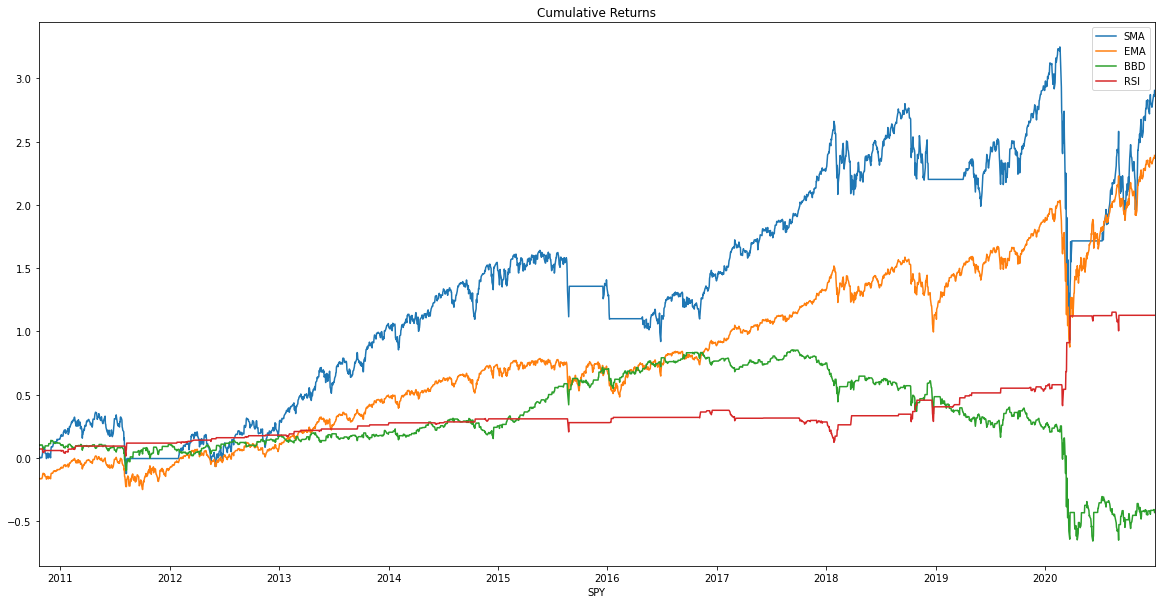

In [720]:
# Plot cumulative returns
# YOUR CODE HERE
cumulative_returns_df.plot(figsize=(20, 10), xlim=(cumulative_returns_df.index.min(),cumulative_returns_df.index.max()), title="Cumulative Returns")
#combined_strategies_cumulative_returns_df.describe()

---
### Descriptive statistics
*Evaluate backtesting*

In [686]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return (%)',
    'Cumulative Returns (%)',
    'Annual Volatility (%)',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown (%)']

columns = ['SMA', 'EMA', 'BBD', 'RSI', 'MACD']

In [687]:
def evalll_df(ticker):
    eval_df = pd.DataFrame(index=metrics, columns=columns)
    eval_df.index.name = f'{ticker}' 
        
    def evall_df(df, signal, ticker):
        eval_df.loc['Cumulative Returns (%)', signal] = round(df['portfolio cumulative returns'][-1],2)
        eval_df.loc['Annual Return (%)', signal] = round((df['portfolio daily returns'].mean() * 252),2)
        eval_df.loc['Annual Volatility (%)', signal] = round(df['portfolio daily returns'].std() * np.sqrt(252),2)
        eval_df.loc['Sharpe Ratio', signal] = round((df['portfolio daily returns'].mean() * 252) / (df['portfolio daily returns'].std() * np.sqrt(252)), 2)
        df.loc[:,'downside returns'] = 0
        df_mask = df['portfolio daily returns'] < 0
        df.loc[df_mask, 'downside returns'] = df['portfolio daily returns']**2
        df_sortino = (df['portfolio daily returns'].mean() * 252) / (np.sqrt(df['downside returns'].mean()) * np.sqrt(252))
        eval_df.loc['Sortino Ratio', signal] = round(df_sortino,2)
        eval_df.loc['Max Drawdown (%)', signal] = round(df['portfolio cumulative returns'].diff(short_window).min(),2)
        return eval_df
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['SMA']] = evall_df(SMA_df, 'SMA', ticker)
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['EMA']] = evall_df(EMA_df, 'EMA', ticker) 
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['BBD']] = evall_df(BBD_df, 'BBD', ticker)
    eval_df.loc[['Cumulative Returns (%)', 'Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)'],
               ['RSI']] = evall_df(RSI_df, 'RSI', ticker)
    return eval_df

evalll_df(ticker)

,SMA,EMA,BBD,RSI,MACD
SPY,,,,,
Annual Return (%),0.18,0.13,0.05,0.07,NaN
Cumulative Returns (%),2.9,2.39,-0.43,1.13,NaN
Annual Volatility (%),0.29,0.21,0.45,0.11,NaN
Sharpe Ratio,0.61,0.63,0.1,0.7,NaN
Sortino Ratio,0.85,0.88,0.16,1.36,NaN
Max Drawdown (%),-2.08,-1.04,-0.91,-0.17,NaN


## Deep learning
---
### Signals df

In [688]:
# Combine signals
signals_df = pd.concat([SMA_df['signal'],
                        EMA_df['signal'],
                        BBD_df['signal'],
                        RSI_df['signal']
                       ], axis=1)
signals_df.columns = ['SMA', 'EMA', 'BBD', 'RSI']
signals_df.index.name = f'{ticker}'
signals_df.dropna(inplace=True)

In [689]:
# Shift signals data by 1 in order to prime for predictions
signals_df = signals_df.shift(1)

In [690]:
# Set dependant variable
signals_df['daily return'] = ETF_df[f'{ticker}'].pct_change(short_window)
signals_df['positive return'] = np.where(signals_df['daily return'] > 0, 1.0, 0.0)
signals_df['negative return'] = np.where(signals_df['daily return'] < 0, -1.0, 0.0)
signals_df['ACTUAL'] = signals_df['positive return'] + signals_df['negative return']
signals_df.drop(columns=['positive return', 'negative return', 'daily return'], inplace=True)
signals_df.dropna(inplace=True)
signals_df.tail()

,SMA,EMA,BBD,RSI,ACTUAL
SPY,,,,,
2020-12-24,1.0,1.0,0.0,0.0,1.0
2020-12-28,1.0,1.0,0.0,0.0,1.0
2020-12-29,1.0,1.0,-1.0,0.0,1.0
2020-12-30,1.0,1.0,-1.0,0.0,1.0
2020-12-31,1.0,1.0,-1.0,0.0,1.0


In [691]:
# Construct training start and end dates

---
### Features df

In [692]:
# Combine signals
features_df = pd.concat([ETF_df[f'{ticker}'], 
                        SMA_df['SMA_long'], SMA_df['SMA_short'],
                        EMA_df['EMA_long'], EMA_df['EMA_short'],
                        BBD_df['BBD_mid'], BBD_df['BBD_std'], BBD_df['BBD_upper'], BBD_df['BBD_lower'],
                        RSI_df['RSI']
                       ], axis=1)

In [693]:
features_df.dropna(inplace=True)
features_df.tail()

,SPY,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
2020-12-24,368.9899,320.438481,355.74239,305.589812,339.752754,367.568975,2.439630,370.008605,365.129345,59.445718
2020-12-28,372.1400,320.944531,356.23499,305.820074,340.198639,367.993475,2.460381,370.453856,365.533094,63.926525
2020-12-29,371.4800,321.604881,356.71959,306.047256,340.629299,368.467475,2.136852,370.604327,366.330623,62.371596
2020-12-30,371.9300,322.193581,357.31779,306.275208,341.060225,368.765475,2.185264,370.950739,366.580211,63.031849
2020-12-31,373.8500,322.857781,357.92799,306.509015,341.511651,369.119980,2.406666,371.526646,366.713314,65.790018


In [694]:
# Looking for missing values
features_df.isnull().sum().sum()

0

In [695]:
features_df.reset_index(inplace=True)
features_df.tail()

,index,SPY,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
2559,2020-12-24,368.9899,320.438481,355.74239,305.589812,339.752754,367.568975,2.439630,370.008605,365.129345,59.445718
2560,2020-12-28,372.1400,320.944531,356.23499,305.820074,340.198639,367.993475,2.460381,370.453856,365.533094,63.926525
2561,2020-12-29,371.4800,321.604881,356.71959,306.047256,340.629299,368.467475,2.136852,370.604327,366.330623,62.371596
2562,2020-12-30,371.9300,322.193581,357.31779,306.275208,341.060225,368.765475,2.185264,370.950739,366.580211,63.031849
2563,2020-12-31,373.8500,322.857781,357.92799,306.509015,341.511651,369.119980,2.406666,371.526646,366.713314,65.790018


In [696]:
X = features_df.iloc[:, 2:].values
y = features_df.iloc[:, 1].values
features_df.set_index('index', inplace=True)
features_df.head()

,SPY,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,RSI
index,,,,,,,,,,
2010-10-21,118.11,112.348736,112.286328,112.278485,112.298625,116.16432,1.524698,117.689018,114.639622,63.955409
2010-10-22,118.38,112.369636,112.481128,112.320272,112.387689,116.34332,1.565692,117.909012,114.777628,64.938834
2010-10-25,118.68,112.390186,112.688728,112.363680,112.479761,116.56282,1.570397,118.133217,114.992423,66.047288
2010-10-26,118.71,112.410086,112.897328,112.406852,112.570846,116.76232,1.577393,118.339713,115.184927,66.162494
2010-10-27,118.38,112.433686,113.072928,112.447349,112.655702,116.95982,1.516093,118.475913,115.443727,63.605826


In [697]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [698]:
# Create a shallow, 1 hidden layer, neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
nn = Sequential()

# Hidden layer
nn.add(Dense(units=8, input_dim=9, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [699]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_1 = nn.fit(X, y, validation_split=0.3, epochs=100)

Epoch 1/100
57/57 [==============================] - 1s 6ms/step - loss: 34171.4528 - mse: 34171.4528 - val_loss: 88684.7500 - val_mse: 88684.7500
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 33918.0450 - mse: 33918.0450 - val_loss: 88417.7109 - val_mse: 88417.7109
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 33221.9629 - mse: 33221.9629 - val_loss: 88140.8516 - val_mse: 88140.8516
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 33532.8964 - mse: 33532.8964 - val_loss: 87951.6562 - val_mse: 87951.6562
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 33816.9399 - mse: 33816.9399 - val_loss: 87837.1406 - val_mse: 87837.1406
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 32624.2637 - mse: 32624.2637 - val_loss: 87751.6562 - val_mse: 87751.6562
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 32362.3482 - mse: 32362.3482 - val_loss: 8768

In [700]:
# Define the model - deep neural network with two layers
nn = Sequential()

# First hidden layer
nn.add(Dense(units=9, input_dim=9, activation="relu"))

# Second hidden layer
nn.add(Dense(units=6, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [701]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_2 = nn.fit(X, y, validation_split=0.3, epochs=100, verbose=0)

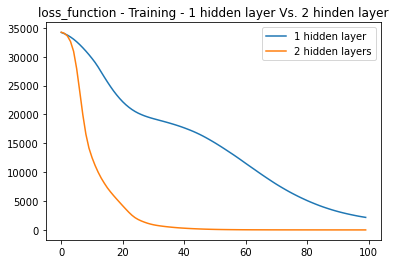

In [702]:
# Plot the loss function of the training results for the two models
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function - Training - 1 hidden layer Vs. 2 hinden layer")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()

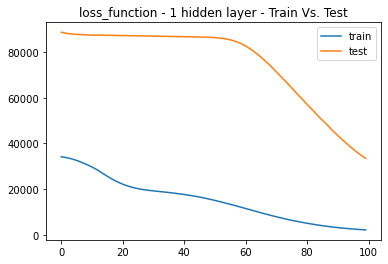

In [703]:
# Plot train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - 1 hidden layer - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

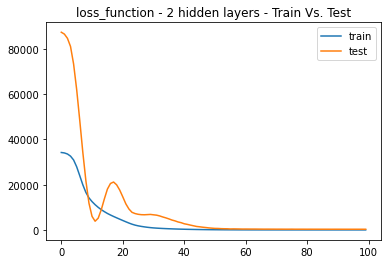

In [704]:
# Plot train vs test for deep net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - 2 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [705]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y = np.array(y).reshape(-1, 1)
y_train = y[: split]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [706]:
y

array([[118.11],
       [118.38],
       [118.68],
       ...,
       [371.48],
       [371.93],
       [373.85]])

In [707]:

y

array([[118.11],
       [118.38],
       [118.68],
       ...,
       [371.48],
       [371.93],
       [373.85]])

In [708]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [709]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [3.27488618e-02]
  [0.00000000e+00]
  [5.70266801e-03]
  [6.68078914e-01]]

 [[9.92831451e-05]
  [7.93025085e-04]
  [2.15141567e-04]
  [3.88563533e-04]
  [7.07633899e-04]
  [3.41050015e-02]
  [8.66671264e-04]
  [6.24702954e-03]
  [6.82011323e-01]]

 [[1.96903654e-04]
  [1.63815860e-03]
  [4.38630431e-04]
  [7.90251926e-04]
  [1.57537491e-03]
  [3.42606475e-02]
  [1.74993240e-03]
  [7.09428250e-03]
  [6.97715051e-01]]] 

X_test sample values:
[[[0.63325687]
  [0.59043344]
  [0.59191154]
  [0.59926835]
  [0.57029809]
  [0.06914013]
  [0.57265023]
  [0.57039345]
  [0.70221631]]

 [[0.63391219]
  [0.59157494]
  [0.59256758]
  [0.60013213]
  [0.57126862]
  [0.07245697]
  [0.57401237]
  [0.57096633]
  [0.7400292 ]]

 [[0.63459411]
  [0.59280845]
  [0.59324721]
  [0.60107112]
  [0.57270958]
  [0.07696847]
  [0.57598558]
  [0.57186617]
  [0.79701635]]]


---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [710]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure


In [711]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 9
dropout_fraction = 0.33

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [712]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [713]:
# Show the model summary
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 9, 9)              396       
_________________________________________________________________
dropout_18 (Dropout)         (None, 9, 9)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 9, 9)              684       
_________________________________________________________________
dropout_19 (Dropout)         (None, 9, 9)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 9)                 684       
_________________________________________________________________
dropout_20 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)               

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [714]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=64, verbose=1)

Epoch 1/100
29/29 [==============================] - 6s 14ms/step - loss: 0.0188
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0272
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0236
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0103
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0048
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0041
Epoch 8/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0038
Epoch 9/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0038: 0s - loss: 0.0
Epoch 10/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 11/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0030
Epoch 12/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 13/

---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [715]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

In [723]:
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)

coeffs = clf.coef_

AttributeError: 'Sequential' object has no attribute 'coef_'

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [716]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [717]:
# Recover the original prices instead of the scaled veRSIon
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [718]:
# Create a DataFrame of Real and Predicted values
actual_vs_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = features_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_vs_predicted.head()

,Actual,Predicted
index,,
2017-12-06,263.21,255.083405
2017-12-07,264.04,255.651154
2017-12-08,265.49,256.427612
2017-12-11,266.34,257.038818
2017-12-12,266.79,257.543457


<AxesSubplot:title={'center':'Actual Vs. Predicted Prices'}, xlabel='index'>

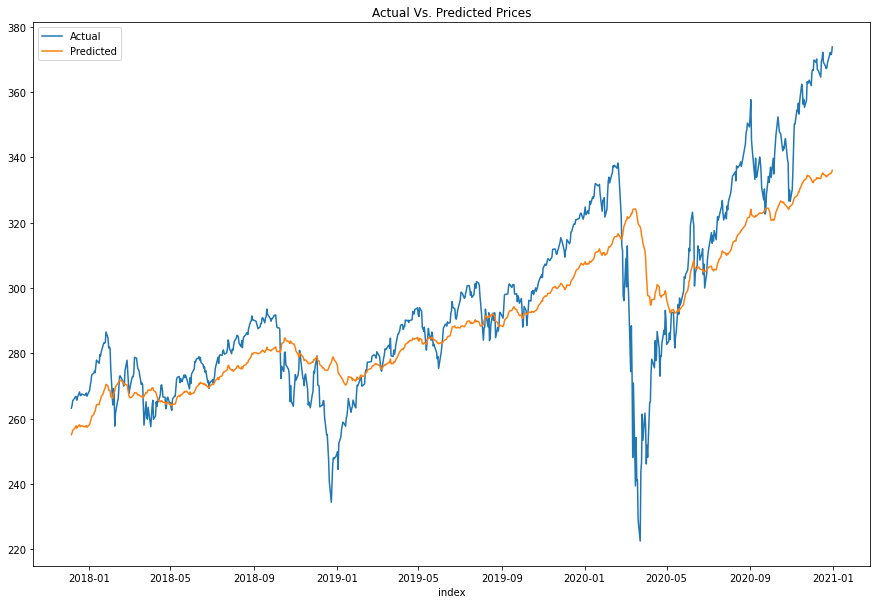

In [719]:
# Plot the real vs predicted prices as a line chart
actual_vs_predicted.plot(title="Actual Vs. Predicted Prices", figsize=(15, 10))

In [722]:
nn_json = nn.to_json()
nn_json

#filepath = Path('deep_model.json')
filepath = 'deep_model.json'
with open(filepath, 'w') as json_file:
  json_file.write(nn_json)
filepath = 'deep_model.h5'
nn.save_weights(filepath)
from tensorflow.keras.models import model_from_json
filepath = 'deep_model.json'
with open(filepath, 'r') as json_file:
  model_json = json_file.read()

loaded_model = model_from_json(model_json)
filepath = 'deep_model.h5'
loaded_model.load_weights(filepath)
actual_vs_predicted['Predicted'] = loaded_model.predict(X)


ValueError: Length of values (2564) does not match length of index (770)